# Exercise 3: Convolutional Neural Networks

Gruppo Stocafisici: Edoardo Antonaci, Angelica Foroni, Francesco Mazza, Leonardo Salicari.

1. Experiment with different architectures (which was left as an open point when “NCONV”
variable was introduced), in particular try at least another version where only one
convolutional layer is introduced instead of two, and where any number of dense layers may
be used, with the global constraint of using a network with at most 600 trainable parameters.
The filter length in the second convolutional layer may be shorter.
Is the number of parameters scaling more quickly by adding Dense layers or Conv1D
layers?
Check which configuration works better by comparing the performances quantitatively.
2. Visualize the “confusion matrix” (look for similar examples in the material available or by
googling)
3. With two convolutional layers, plot also the weights of the second layer and try to see if
regularization may improve the performances by varying the parameter lambda of the L1 or
of the L2 regularization; see lambda in eqs.(43) and (52) in the review. There is also a mixed
version (l1_l2?) that can be tried. Is any value of lambda good? Is there any intermediate
value where the performances of the network are better? Is there any improvement in the
visualization and understanding of the weights in the filters? Note that the regularization we
introduced acts on the w’s, not on the biases. One can also try the equivalent procedure for
biases or for the output of the relu units (see Keras doc.), if there is any reason for
suspecting that it may help. In our case, the logic was to let the weights of the filters go to
zero if not needed, hence that kind of regularization was selected.
4. By reducing the signal-to-noise ratio, namely the amplitude of the external signal in the data
(A) with respect to the step typical size of the jump process, check where the network starts
to fail discriminating the categories.

### Loading dataset
We are going to use the dataset generated during the lecture

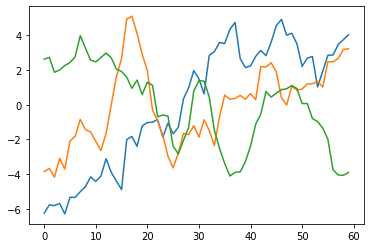

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Version compatible with git folder
name = '_ts_L60_Z12_A12_DX50_bias5_N10000.csv'
xname = 'DATA/x' + name
yname = 'DATA/y' + name

# Other version
#name = '_ts_L60_Z12_A12_DX50_bias5_N10000.csv'
#xname = fname
#yname = 'y' + name

# Dataset
x = np.loadtxt(xname, delimiter=',', dtype=float)
N = x.shape[0]
L = x.shape[1]

# Labels
categ = np.loadtxt(yname, delimiter=',', dtype=int)
n_class = 3
y = np.zeros((N, n_class ))
for i in range(N):
    y[i][categ[i]] = 1.

# Removing avg and scaling data
x_avg = np.mean(x, axis=1).reshape(N,1) # average over sample (i.e. over rows)
x = (x - x_avg)/100 # one line to remove avg and scale; faster than a for loop
    
# Training and Validation
# Note, these are view, not copies
train_frac = .8
N_train = int(N*train_frac)
x_train = x[0:N_train,:]
y_train = y[0:N_train,:]
x_val = x[N_train:,:]
y_val = y[N_train:,:]

# Plotting some data
for k in range(3):
    plt.plot(x_train[k])
    
# Reshape for Keras
# Hence adding an extra dim wich correspond to the depth 
x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)

input_size = (L,1)

## 1: CNN with different topologies

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils.layer_utils import count_params # for count number of parameters
from keras.losses import categorical_crossentropy
from keras.regularizers import l1, l2, l1_l2
from keras import initializers
from keras import optimizers

def create_model(NCONV=1, n_dense_layers=1, kernel_size_diff=1, summary=False, reg=l1(0.001)):
    ''' 
    Creates a CNN with different topologies by changing NCONV 
    Returns the model and the number of trainable parameters
    
    n_dense_layers = number of dense layers in the CNN
    kernel_size_diff = (kernel_size first Conv layer) - (kernel_size second Conv layer)
    summary = print model.summary()
    
    NCONV == 1:
        From baiesi lecture
        Conv -> AvgPadding -> Conv -> Fattern -> Dense*(n_dense_layers) -> Dense (output)
    NCONV == 2: 
        Only one Conv layer
        Conv -> AvgPadding -> Fattern -> Dense*(n_dense_layers) -> Dense (output)
        
    '''
    if n_dense_layers < 1:
        raise('n_dense_layer must be int and >= 1')
        
    # Used to initialize kernel 
    init = initializers.RandomNormal(mean = 0,
                                    stddev = .05,
                                    seed = 12345) # reproducibility in training
    model = Sequential()

    if NCONV == 1:
        model.add( Conv1D(filters=5,
                          kernel_size = 11,                              
                          kernel_initializer = init,
                          kernel_regularizer = reg,
                          activation = 'relu',
                          input_shape = input_size
                         ) )
        model.add( AveragePooling1D(5) ) # max pooling windows' size
        model.add( Conv1D(filters=5, 
                          kernel_size = 11 - kernel_size_diff, 
                          kernel_regularizer = reg,
                          activation = 'relu',) )
        model.add( Flatten() )
        for _ in range(n_dense_layers): # variable number of layers
            model.add( Dense(10, activation='relu') )
        model.add( Dropout(0.2) )
        
    elif NCONV == 2:
        model.add( Conv1D(filters=5,
                          kernel_size = 11,                              
                          kernel_initializer = init,
                          kernel_regularizer = reg,
                          activation = 'relu',
                          input_shape = input_size
                         ) )
        model.add( AveragePooling1D(5) ) # max pooling windows' size
        model.add( Flatten() )
        for _ in range(n_dense_layers): # variable number of layers
            model.add( Dense(10, activation='relu') )
        model.add( Dropout(0.2) )
    else:
        raise('NCONV must be an int: 1 or 2')
        
    # Output layer
    model.add(Dense(n_class, activation='softmax')) 
    
    # print model's details
    if summary: print(model.summary())
    # Number of trainable parameters
    trainable_count = count_params(model.trainable_weights)
    
    # Compiling model
    opt = optimizers.Nadam()
    model.compile( loss = categorical_crossentropy,
              optimizer = opt,
              metrics = ['accuracy'])
    
    return (model, trainable_count)

### Training and test performance

 Is the number of parameters scaling more quickly by adding Dense layers or Conv1D layers?

Text(0, 0.5, '# of trainable parameters')

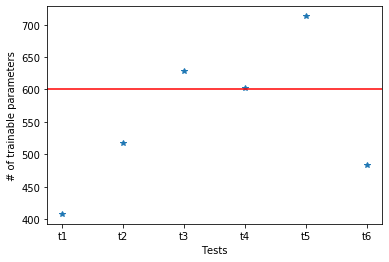

In [14]:
# Define dicts to test different topologies
# t1 == test 1
t1 = dict(NCONV = 1, n_dense_layers = 1, kernel_size_diff = 1)
t2 = dict(NCONV = 1, n_dense_layers = 2, kernel_size_diff = 1)
t3 = dict(NCONV = 1, n_dense_layers = 3, kernel_size_diff = 1)
t4 = dict(NCONV = 2, n_dense_layers = 1, kernel_size_diff = 1)
t5 = dict(NCONV = 2, n_dense_layers = 2, kernel_size_diff = 1)
t6 = dict(NCONV = 1, n_dense_layers = 1, kernel_size_diff = 4)

# Array with tests
tests = [t1,t2,t3,t4,t5,t6]
# Array with names for plotting porpuses
tests_plot = ['t1','t2','t3','t4','t5','t6']
# Array to save # of parameters
params = [0] * len(tests)

for idx,t in enumerate(tests):
    _, params[idx] = create_model(**t, summary=False) # **t is the syntax to 'unpack' values from dict
    
# Visualising number of parameters
plt.close()
plt.plot(tests_plot, params, '*')
plt.axhline(y=600, color='red') # line of 600 parameters
plt.xlabel('Tests')
plt.ylabel('# of trainable parameters')

#### Comment
It's seems like that removing a `Conv1D` layer the number of trainable parameters grows. Looking at the summary of the models, this apparent contradiction seems to be solve by the fact that in the case of 2 convolutional layers the `output size` of the layer's output is smaller compared to the model with only one convolutional layer.

Than, the fully connected layers (the `Dense` one) han a number of trainable parameters related to the number of weights and biases which grows quickly with the `output size` of the previous layer. Hence, the one-convolutional-layer model has more parameters due to its bigger output given to the fully connected layer.

For more info, use the option `summary=True` in the `create_model()` function's call.

### Performance comparison
It'll be trained models relative to configurations `t2`, `t4` and `t6`


In [15]:
model2, _ = create_model(**t2)
model4, _ = create_model(**t4)
model6, _ = create_model(**t6)

# Training
batch_size = 250
epochs = 125

fit2 = model2.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose = 2,
                shuffle = True)
fit4 = model4.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose = 2,
                shuffle = True)
fit6 = model6.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
               validation_data=(x_val,y_val),
                verbose = 2,
                shuffle = True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/125
 - 5s - loss: 1.1262 - accuracy: 0.3836 - val_loss: 1.1055 - val_accuracy: 0.4160
Epoch 2/125
 - 1s - loss: 1.0657 - accuracy: 0.4791 - val_loss: 0.9910 - val_accuracy: 0.5725
Epoch 3/125
 - 1s - loss: 0.9409 - accuracy: 0.5659 - val_loss: 0.8671 - val_accuracy: 0.6195
Epoch 4/125
 - 1s - loss: 0.8537 - accuracy: 0.6037 - val_loss: 0.7960 - val_accuracy: 0.6505
Epoch 5/125
 - 1s - loss: 0.8080 - accuracy: 0.6336 - val_loss: 0.7792 - val_accuracy: 0.6710
Epoch 6/125
 - 1s - loss: 0.7896 - accuracy: 0.6434 - val_loss: 0.7695 - val_accuracy: 0.6780
Epoch 7/125
 - 1s - loss: 0.7708 - accuracy: 0.6510 - val_loss: 0.7512 - val_accuracy: 0.6885
Epoch 8/125
 - 1s - loss: 0.7557 - accuracy: 0.6701 - val_loss: 0.7320 - val_accuracy: 0.6905
Epoch 9/125
 - 1s - loss: 0.7424 - accuracy: 0.6800 - val_loss: 0.7117 - val_accuracy: 0.7210
Epoch 10/125
 - 1s - loss: 0.7236 - accuracy: 0.6989 - val_loss: 0.6842 - val_accuracy: 0.7355
Epoch 11/12

Epoch 87/125
 - 1s - loss: 0.3768 - accuracy: 0.8766 - val_loss: 0.3606 - val_accuracy: 0.8815
Epoch 88/125
 - 1s - loss: 0.3714 - accuracy: 0.8751 - val_loss: 0.3561 - val_accuracy: 0.8865
Epoch 89/125
 - 1s - loss: 0.3701 - accuracy: 0.8733 - val_loss: 0.3558 - val_accuracy: 0.8815
Epoch 90/125
 - 1s - loss: 0.3697 - accuracy: 0.8763 - val_loss: 0.3585 - val_accuracy: 0.8825
Epoch 91/125
 - 1s - loss: 0.3680 - accuracy: 0.8769 - val_loss: 0.3523 - val_accuracy: 0.8870
Epoch 92/125
 - 1s - loss: 0.3698 - accuracy: 0.8751 - val_loss: 0.3549 - val_accuracy: 0.8840
Epoch 93/125
 - 1s - loss: 0.3703 - accuracy: 0.8794 - val_loss: 0.3594 - val_accuracy: 0.8840
Epoch 94/125
 - 1s - loss: 0.3662 - accuracy: 0.8773 - val_loss: 0.3601 - val_accuracy: 0.8810
Epoch 95/125
 - 1s - loss: 0.3663 - accuracy: 0.8789 - val_loss: 0.3541 - val_accuracy: 0.8845
Epoch 96/125
 - 2s - loss: 0.3684 - accuracy: 0.8779 - val_loss: 0.3565 - val_accuracy: 0.8820
Epoch 97/125
 - 1s - loss: 0.3692 - accuracy: 0.87

Epoch 48/125
 - 1s - loss: 0.3810 - accuracy: 0.8593 - val_loss: 0.3534 - val_accuracy: 0.8760
Epoch 49/125
 - 1s - loss: 0.3912 - accuracy: 0.8566 - val_loss: 0.3470 - val_accuracy: 0.8750
Epoch 50/125
 - 1s - loss: 0.3797 - accuracy: 0.8627 - val_loss: 0.3514 - val_accuracy: 0.8780
Epoch 51/125
 - 1s - loss: 0.3860 - accuracy: 0.8594 - val_loss: 0.3482 - val_accuracy: 0.8770
Epoch 52/125
 - 1s - loss: 0.3804 - accuracy: 0.8611 - val_loss: 0.3510 - val_accuracy: 0.8785
Epoch 53/125
 - 1s - loss: 0.3774 - accuracy: 0.8649 - val_loss: 0.3482 - val_accuracy: 0.8795
Epoch 54/125
 - 1s - loss: 0.3795 - accuracy: 0.8606 - val_loss: 0.3476 - val_accuracy: 0.8780
Epoch 55/125
 - 1s - loss: 0.3773 - accuracy: 0.8645 - val_loss: 0.3464 - val_accuracy: 0.8775
Epoch 56/125
 - 1s - loss: 0.3754 - accuracy: 0.8660 - val_loss: 0.3475 - val_accuracy: 0.8790
Epoch 57/125
 - 1s - loss: 0.3780 - accuracy: 0.8658 - val_loss: 0.3437 - val_accuracy: 0.8775
Epoch 58/125
 - 1s - loss: 0.3734 - accuracy: 0.86

Epoch 9/125
 - 1s - loss: 0.7611 - accuracy: 0.6796 - val_loss: 0.7274 - val_accuracy: 0.7090
Epoch 10/125
 - 1s - loss: 0.7349 - accuracy: 0.6948 - val_loss: 0.7096 - val_accuracy: 0.7265
Epoch 11/125
 - 1s - loss: 0.7096 - accuracy: 0.7135 - val_loss: 0.6754 - val_accuracy: 0.7475
Epoch 12/125
 - 1s - loss: 0.6888 - accuracy: 0.7258 - val_loss: 0.6499 - val_accuracy: 0.7715
Epoch 13/125
 - 1s - loss: 0.6713 - accuracy: 0.7383 - val_loss: 0.6298 - val_accuracy: 0.7840
Epoch 14/125
 - 1s - loss: 0.6425 - accuracy: 0.7581 - val_loss: 0.6111 - val_accuracy: 0.7910
Epoch 15/125
 - 1s - loss: 0.6219 - accuracy: 0.7705 - val_loss: 0.5926 - val_accuracy: 0.7980
Epoch 16/125
 - 1s - loss: 0.6155 - accuracy: 0.7695 - val_loss: 0.5824 - val_accuracy: 0.7965
Epoch 17/125
 - 0s - loss: 0.5962 - accuracy: 0.7734 - val_loss: 0.5767 - val_accuracy: 0.8050
Epoch 18/125
 - 1s - loss: 0.5892 - accuracy: 0.7834 - val_loss: 0.5529 - val_accuracy: 0.8145
Epoch 19/125
 - 1s - loss: 0.5708 - accuracy: 0.792

Epoch 96/125
 - 1s - loss: 0.4121 - accuracy: 0.8620 - val_loss: 0.3990 - val_accuracy: 0.8650
Epoch 97/125
 - 1s - loss: 0.4059 - accuracy: 0.8662 - val_loss: 0.4036 - val_accuracy: 0.8605
Epoch 98/125
 - 1s - loss: 0.4059 - accuracy: 0.8673 - val_loss: 0.3961 - val_accuracy: 0.8675
Epoch 99/125
 - 1s - loss: 0.4044 - accuracy: 0.8694 - val_loss: 0.3956 - val_accuracy: 0.8615
Epoch 100/125
 - 1s - loss: 0.4088 - accuracy: 0.8661 - val_loss: 0.3933 - val_accuracy: 0.8690
Epoch 101/125
 - 1s - loss: 0.4010 - accuracy: 0.8698 - val_loss: 0.3948 - val_accuracy: 0.8720
Epoch 102/125
 - 1s - loss: 0.4011 - accuracy: 0.8687 - val_loss: 0.3968 - val_accuracy: 0.8655
Epoch 103/125
 - 1s - loss: 0.4040 - accuracy: 0.8645 - val_loss: 0.3973 - val_accuracy: 0.8710
Epoch 104/125
 - 1s - loss: 0.4038 - accuracy: 0.8633 - val_loss: 0.3959 - val_accuracy: 0.8695
Epoch 105/125
 - 1s - loss: 0.4035 - accuracy: 0.8673 - val_loss: 0.3975 - val_accuracy: 0.8635
Epoch 106/125
 - 1s - loss: 0.3973 - accurac

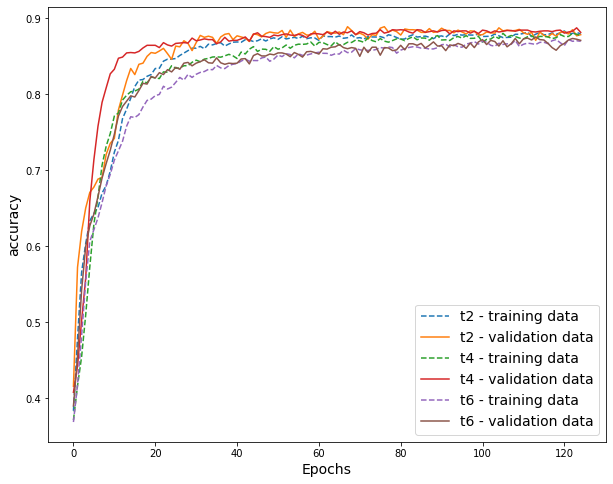

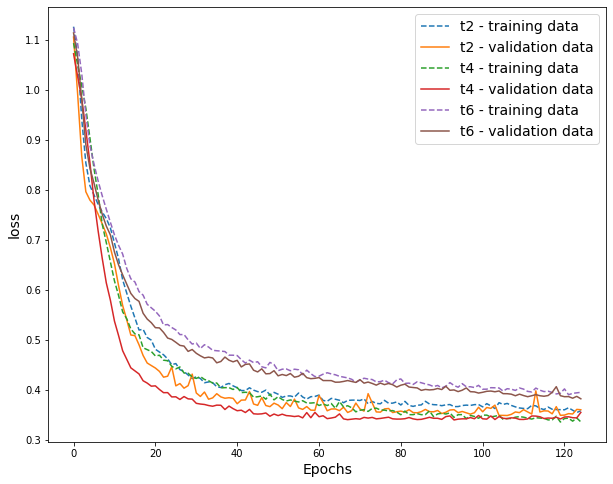

In [16]:
# Grafical comparison

fits = [fit2,fit4,fit6]

plt.close()

# Accuracy
plt.figure(figsize=(10,8))
for fit, test in zip(fits,tests_plot[1::2]):
    
    plt.plot(fit.history['accuracy'], '--',
            label = test + ' - training data')
    
    plt.plot(fit.history['val_accuracy'],
            label = test + ' - validation data') 

fontsize = 14
plt.ylabel('accuracy', fontsize=fontsize)
plt.xlabel('Epochs', fontsize=fontsize)
plt.legend(loc='lower right', fontsize=fontsize)    
plt.show()

# Loss
plt.figure(figsize=(10,8))
for fit, test in zip(fits,tests_plot[1::2]):
    
    plt.plot(fit.history['loss'], '--',
            label = test + ' - training data')
    
    plt.plot(fit.history['val_loss'],
            label = test + ' - validation data') 

fontsize = 14
plt.ylabel('loss', fontsize=fontsize)
plt.xlabel('Epochs', fontsize=fontsize)
plt.legend(loc='upper right', fontsize=fontsize)    
plt.show()

## 2: Confusion Matrix

As it can be seen from the [relative documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), the `sklearn.metrics.confusion_matrix` function evaluates classification accuracy by computing the confusion matrix with each row corresponding to the true class, and each column corresponding to the predected one. Notice that [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix) and other references may use different convention for axes.

By definition, entry $C_{ij}$ in a confusion matrix $C$ is the number of observations actually in group $i$, but predicted to be in group $j$. Therefore, the diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

We compute the confusion matrix for the model2, which was the one with the best performance.

In [17]:
from sklearn.metrics import confusion_matrix

# Uncomment to have a look at the test (val) data one more time:
#print('x, of shape {}: \n'.format(x_val.shape), x_val, '\n')
#print('y, of shape {}: \n'.format(y.shape), y_val, '\n')

y_pred = model6.predict(x_val, batch_size = batch_size)
print('The predicted values are:\n', y_pred)

The predicted values are:
 [[1.0324286e-03 6.2909815e-04 9.9833846e-01]
 [4.3825597e-01 2.1722084e-01 3.4452322e-01]
 [6.7433948e-03 9.3070036e-01 6.2556192e-02]
 ...
 [2.0449005e-02 9.6452767e-01 1.5023332e-02]
 [3.3235028e-03 2.8933710e-04 9.9638712e-01]
 [9.4968218e-01 2.3544140e-02 2.6773732e-02]]


In order to compute the confusion matrix, we feed to the confusion_matrix function the index of the maximum value for each row, both for the true labels and for the predicted ones. That index corresponds, moreover, to the wanted category (0 = no signal, 1 = positive signal, 2 = negative signal)

In [18]:
conf_mat = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(conf_mat)

[[577  64  26]
 [ 33 599  34]
 [ 53  48 566]]


Let's do a rapid check: we compute the accuracy of the model as given by the confusion matrix, and visually compare it to the one plotted previously. 

In [19]:
# Sum the element on the diagonal
sum_diag = np.sum(np.diag(conf_mat)) 
# Sum the offdiagonal terms
sum_offd = np.sum(np.extract(1-np.eye(3), conf_mat))

total_n = sum_diag + sum_offd
# Check if it equals the length of y_val (as it should be):
# total_n == len(y_val)

# Computing and printing the accuracy
print('The percentage of corrected categorized data is {} %'.format(100*sum_diag/total_n) )

The percentage of corrected categorized data is 87.1 %


The result is, therefore, qualitatively consistent. 

Let's plot the confusion matrix:

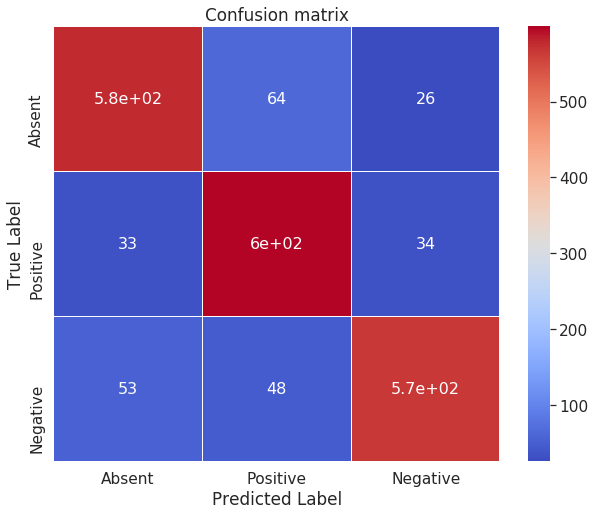

In [20]:
import seaborn as sns
import pandas as pd

# Feed the confusion matrix into a pandas dataframe, to ease the labeling process in the plot
df_cm = pd.DataFrame(conf_mat, columns = ['Absent', 'Positive', 'Negative'],
                    index = ['Absent', 'Positive', 'Negative'])

plt.figure(figsize=(10,8))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="coolwarm",
           linewidths=.5)
plt.title("Confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

## 3. Regularization
With two convolutional layers, plot also the weights of the second layer and try to see if regularization may improve the performances by varying the parameter lambda of the L1 or of the L2 regularization; Is any value of lambda good? Is there any intermediate value where the performances of the network are better? Is there any improvement in the visualization and understanding of the weights in the filters? 

In [21]:
# import regularizers
from keras.regularizers import l1, l2, l1_l2
# instantiate regularizer
reg11 = l1(0.0001)
reg12 = l1(0.001)
reg13 = l1(0.01)
reg21 = l2(0.0001)
reg22 = l2(0.001)
reg23 = l2(0.01)
reg3 = l1_l2(0.01,0.001)

# t6 because in retraining model it was best
model_l1_1, _ = create_model(**t6,reg=reg11)
model_l1_2, _ = create_model(**t6,reg=reg12)
model_l1_3, _ = create_model(**t6,reg=reg13)
model_l2_1, _ = create_model(**t6,reg=reg21)
model_l2_2, _ = create_model(**t6,reg=reg22)
model_l2_3, _ = create_model(**t6,reg=reg23)
model_l1_l2, _ = create_model(**t6,reg=reg3)

#### Training various models

In [22]:
fits = []
model_list=[model_l1_1, model_l1_2, model_l1_3, model_l2_1,
            model_l2_2, model_l2_3, model_l1_l2]

for model in model_list:
    fits.append(model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose = 2,
                shuffle = True))


Train on 8000 samples, validate on 2000 samples
Epoch 1/125
 - 4s - loss: 1.0936 - accuracy: 0.3409 - val_loss: 1.0722 - val_accuracy: 0.4080
Epoch 2/125
 - 1s - loss: 1.0491 - accuracy: 0.4521 - val_loss: 1.0077 - val_accuracy: 0.4690
Epoch 3/125
 - 1s - loss: 0.9826 - accuracy: 0.5249 - val_loss: 0.9422 - val_accuracy: 0.5625
Epoch 4/125
 - 1s - loss: 0.9126 - accuracy: 0.5805 - val_loss: 0.8488 - val_accuracy: 0.6560
Epoch 5/125
 - 1s - loss: 0.8196 - accuracy: 0.6492 - val_loss: 0.7333 - val_accuracy: 0.7150
Epoch 6/125
 - 1s - loss: 0.7262 - accuracy: 0.7005 - val_loss: 0.6594 - val_accuracy: 0.7505
Epoch 7/125
 - 1s - loss: 0.6765 - accuracy: 0.7226 - val_loss: 0.6329 - val_accuracy: 0.7595
Epoch 8/125
 - 1s - loss: 0.6458 - accuracy: 0.7424 - val_loss: 0.6006 - val_accuracy: 0.7795
Epoch 9/125
 - 1s - loss: 0.6279 - accuracy: 0.7523 - val_loss: 0.5821 - val_accuracy: 0.7870
Epoch 10/125
 - 1s - loss: 0.6063 - accuracy: 0.7570 - val_loss: 0.5757 - val_accuracy: 0.7890
Epoch 11/12

Epoch 87/125
 - 1s - loss: 0.3532 - accuracy: 0.8750 - val_loss: 0.3525 - val_accuracy: 0.8705
Epoch 88/125
 - 1s - loss: 0.3527 - accuracy: 0.8761 - val_loss: 0.3578 - val_accuracy: 0.8715
Epoch 89/125
 - 1s - loss: 0.3522 - accuracy: 0.8742 - val_loss: 0.3565 - val_accuracy: 0.8700
Epoch 90/125
 - 1s - loss: 0.3472 - accuracy: 0.8749 - val_loss: 0.3501 - val_accuracy: 0.8770
Epoch 91/125
 - 1s - loss: 0.3527 - accuracy: 0.8709 - val_loss: 0.3496 - val_accuracy: 0.8735
Epoch 92/125
 - 1s - loss: 0.3499 - accuracy: 0.8733 - val_loss: 0.3637 - val_accuracy: 0.8695
Epoch 93/125
 - 1s - loss: 0.3483 - accuracy: 0.8751 - val_loss: 0.3530 - val_accuracy: 0.8735
Epoch 94/125
 - 1s - loss: 0.3544 - accuracy: 0.8736 - val_loss: 0.3489 - val_accuracy: 0.8720
Epoch 95/125
 - 1s - loss: 0.3503 - accuracy: 0.8750 - val_loss: 0.3503 - val_accuracy: 0.8745
Epoch 96/125
 - 1s - loss: 0.3444 - accuracy: 0.8760 - val_loss: 0.3643 - val_accuracy: 0.8730
Epoch 97/125
 - 1s - loss: 0.3452 - accuracy: 0.87

Epoch 48/125
 - 0s - loss: 0.4372 - accuracy: 0.8540 - val_loss: 0.4273 - val_accuracy: 0.8525
Epoch 49/125
 - 0s - loss: 0.4432 - accuracy: 0.8543 - val_loss: 0.4314 - val_accuracy: 0.8555
Epoch 50/125
 - 1s - loss: 0.4399 - accuracy: 0.8556 - val_loss: 0.4241 - val_accuracy: 0.8535
Epoch 51/125
 - 1s - loss: 0.4364 - accuracy: 0.8587 - val_loss: 0.4261 - val_accuracy: 0.8565
Epoch 52/125
 - 1s - loss: 0.4351 - accuracy: 0.8536 - val_loss: 0.4207 - val_accuracy: 0.8585
Epoch 53/125
 - 1s - loss: 0.4357 - accuracy: 0.8553 - val_loss: 0.4226 - val_accuracy: 0.8565
Epoch 54/125
 - 1s - loss: 0.4275 - accuracy: 0.8574 - val_loss: 0.4180 - val_accuracy: 0.8615
Epoch 55/125
 - 1s - loss: 0.4274 - accuracy: 0.8565 - val_loss: 0.4146 - val_accuracy: 0.8575
Epoch 56/125
 - 1s - loss: 0.4242 - accuracy: 0.8594 - val_loss: 0.4145 - val_accuracy: 0.8625
Epoch 57/125
 - 1s - loss: 0.4215 - accuracy: 0.8618 - val_loss: 0.4172 - val_accuracy: 0.8630
Epoch 58/125
 - 1s - loss: 0.4200 - accuracy: 0.86

Epoch 9/125
 - 1s - loss: 0.7735 - accuracy: 0.7160 - val_loss: 0.7356 - val_accuracy: 0.7620
Epoch 10/125
 - 1s - loss: 0.7501 - accuracy: 0.7346 - val_loss: 0.7226 - val_accuracy: 0.7680
Epoch 11/125
 - 1s - loss: 0.7333 - accuracy: 0.7500 - val_loss: 0.6945 - val_accuracy: 0.7880
Epoch 12/125
 - 1s - loss: 0.7195 - accuracy: 0.7589 - val_loss: 0.6843 - val_accuracy: 0.7960
Epoch 13/125
 - 0s - loss: 0.7058 - accuracy: 0.7644 - val_loss: 0.6854 - val_accuracy: 0.7960
Epoch 14/125
 - 0s - loss: 0.6820 - accuracy: 0.7760 - val_loss: 0.6510 - val_accuracy: 0.8055
Epoch 15/125
 - 1s - loss: 0.6824 - accuracy: 0.7738 - val_loss: 0.6396 - val_accuracy: 0.8105
Epoch 16/125
 - 0s - loss: 0.6619 - accuracy: 0.7896 - val_loss: 0.6915 - val_accuracy: 0.7780
Epoch 17/125
 - 0s - loss: 0.6569 - accuracy: 0.7832 - val_loss: 0.6174 - val_accuracy: 0.8180
Epoch 18/125
 - 0s - loss: 0.6384 - accuracy: 0.8025 - val_loss: 0.6095 - val_accuracy: 0.8255
Epoch 19/125
 - 0s - loss: 0.6323 - accuracy: 0.800

Epoch 96/125
 - 1s - loss: 0.4458 - accuracy: 0.8725 - val_loss: 0.4488 - val_accuracy: 0.8680
Epoch 97/125
 - 1s - loss: 0.4402 - accuracy: 0.8759 - val_loss: 0.4375 - val_accuracy: 0.8780
Epoch 98/125
 - 1s - loss: 0.4427 - accuracy: 0.8717 - val_loss: 0.4308 - val_accuracy: 0.8760
Epoch 99/125
 - 1s - loss: 0.4376 - accuracy: 0.8777 - val_loss: 0.4356 - val_accuracy: 0.8775
Epoch 100/125
 - 1s - loss: 0.4375 - accuracy: 0.8740 - val_loss: 0.4269 - val_accuracy: 0.8800
Epoch 101/125
 - 1s - loss: 0.4379 - accuracy: 0.8746 - val_loss: 0.4251 - val_accuracy: 0.8800
Epoch 102/125
 - 1s - loss: 0.4434 - accuracy: 0.8721 - val_loss: 0.4295 - val_accuracy: 0.8780
Epoch 103/125
 - 1s - loss: 0.4357 - accuracy: 0.8761 - val_loss: 0.4280 - val_accuracy: 0.8825
Epoch 104/125
 - 1s - loss: 0.4371 - accuracy: 0.8741 - val_loss: 0.4316 - val_accuracy: 0.8785
Epoch 105/125
 - 1s - loss: 0.4319 - accuracy: 0.8760 - val_loss: 0.4288 - val_accuracy: 0.8820
Epoch 106/125
 - 1s - loss: 0.4357 - accurac

Epoch 57/125
 - 1s - loss: 0.3873 - accuracy: 0.8630 - val_loss: 0.3585 - val_accuracy: 0.8695
Epoch 58/125
 - 1s - loss: 0.3915 - accuracy: 0.8614 - val_loss: 0.3579 - val_accuracy: 0.8655
Epoch 59/125
 - 1s - loss: 0.3871 - accuracy: 0.8656 - val_loss: 0.3512 - val_accuracy: 0.8710
Epoch 60/125
 - 1s - loss: 0.3847 - accuracy: 0.8661 - val_loss: 0.3497 - val_accuracy: 0.8710
Epoch 61/125
 - 1s - loss: 0.3786 - accuracy: 0.8668 - val_loss: 0.3524 - val_accuracy: 0.8725
Epoch 62/125
 - 1s - loss: 0.3877 - accuracy: 0.8677 - val_loss: 0.3468 - val_accuracy: 0.8705
Epoch 63/125
 - 1s - loss: 0.3866 - accuracy: 0.8668 - val_loss: 0.3486 - val_accuracy: 0.8700
Epoch 64/125
 - 0s - loss: 0.3828 - accuracy: 0.8684 - val_loss: 0.3431 - val_accuracy: 0.8740
Epoch 65/125
 - 0s - loss: 0.3833 - accuracy: 0.8671 - val_loss: 0.3451 - val_accuracy: 0.8700
Epoch 66/125
 - 0s - loss: 0.3759 - accuracy: 0.8645 - val_loss: 0.3417 - val_accuracy: 0.8725
Epoch 67/125
 - 1s - loss: 0.3787 - accuracy: 0.86

Epoch 18/125
 - 1s - loss: 0.5778 - accuracy: 0.7794 - val_loss: 0.5088 - val_accuracy: 0.8125
Epoch 19/125
 - 1s - loss: 0.5663 - accuracy: 0.7830 - val_loss: 0.5023 - val_accuracy: 0.8155
Epoch 20/125
 - 1s - loss: 0.5615 - accuracy: 0.7850 - val_loss: 0.4970 - val_accuracy: 0.8180
Epoch 21/125
 - 1s - loss: 0.5531 - accuracy: 0.7865 - val_loss: 0.4839 - val_accuracy: 0.8270
Epoch 22/125
 - 0s - loss: 0.5471 - accuracy: 0.7897 - val_loss: 0.4869 - val_accuracy: 0.8255
Epoch 23/125
 - 1s - loss: 0.5399 - accuracy: 0.7940 - val_loss: 0.4739 - val_accuracy: 0.8340
Epoch 24/125
 - 1s - loss: 0.5278 - accuracy: 0.8006 - val_loss: 0.4706 - val_accuracy: 0.8350
Epoch 25/125
 - 1s - loss: 0.5168 - accuracy: 0.8054 - val_loss: 0.4619 - val_accuracy: 0.8405
Epoch 26/125
 - 1s - loss: 0.5090 - accuracy: 0.8109 - val_loss: 0.4465 - val_accuracy: 0.8440
Epoch 27/125
 - 1s - loss: 0.5010 - accuracy: 0.8098 - val_loss: 0.4603 - val_accuracy: 0.8380
Epoch 28/125
 - 1s - loss: 0.5063 - accuracy: 0.81

Epoch 105/125
 - 1s - loss: 0.3348 - accuracy: 0.8841 - val_loss: 0.3354 - val_accuracy: 0.8890
Epoch 106/125
 - 1s - loss: 0.3292 - accuracy: 0.8874 - val_loss: 0.3481 - val_accuracy: 0.8785
Epoch 107/125
 - 1s - loss: 0.3301 - accuracy: 0.8841 - val_loss: 0.3460 - val_accuracy: 0.8770
Epoch 108/125
 - 0s - loss: 0.3299 - accuracy: 0.8832 - val_loss: 0.3393 - val_accuracy: 0.8830
Epoch 109/125
 - 0s - loss: 0.3292 - accuracy: 0.8888 - val_loss: 0.3500 - val_accuracy: 0.8780
Epoch 110/125
 - 0s - loss: 0.3280 - accuracy: 0.8869 - val_loss: 0.3431 - val_accuracy: 0.8790
Epoch 111/125
 - 0s - loss: 0.3284 - accuracy: 0.8849 - val_loss: 0.3374 - val_accuracy: 0.8835
Epoch 112/125
 - 1s - loss: 0.3255 - accuracy: 0.8879 - val_loss: 0.3364 - val_accuracy: 0.8830
Epoch 113/125
 - 0s - loss: 0.3274 - accuracy: 0.8875 - val_loss: 0.3342 - val_accuracy: 0.8870
Epoch 114/125
 - 1s - loss: 0.3270 - accuracy: 0.8855 - val_loss: 0.3425 - val_accuracy: 0.8795
Epoch 115/125
 - 1s - loss: 0.3304 - acc

Epoch 66/125
 - 1s - loss: 0.3882 - accuracy: 0.8723 - val_loss: 0.3796 - val_accuracy: 0.8795
Epoch 67/125
 - 1s - loss: 0.3910 - accuracy: 0.8725 - val_loss: 0.3770 - val_accuracy: 0.8795
Epoch 68/125
 - 1s - loss: 0.3868 - accuracy: 0.8727 - val_loss: 0.3762 - val_accuracy: 0.8785
Epoch 69/125
 - 1s - loss: 0.3850 - accuracy: 0.8715 - val_loss: 0.3753 - val_accuracy: 0.8795
Epoch 70/125
 - 1s - loss: 0.3895 - accuracy: 0.8723 - val_loss: 0.3853 - val_accuracy: 0.8760
Epoch 71/125
 - 1s - loss: 0.3843 - accuracy: 0.8760 - val_loss: 0.3733 - val_accuracy: 0.8765
Epoch 72/125
 - 1s - loss: 0.3896 - accuracy: 0.8721 - val_loss: 0.3736 - val_accuracy: 0.8810
Epoch 73/125
 - 1s - loss: 0.3780 - accuracy: 0.8756 - val_loss: 0.3710 - val_accuracy: 0.8830
Epoch 74/125
 - 1s - loss: 0.3803 - accuracy: 0.8771 - val_loss: 0.3695 - val_accuracy: 0.8795
Epoch 75/125
 - 1s - loss: 0.3824 - accuracy: 0.8763 - val_loss: 0.3698 - val_accuracy: 0.8825
Epoch 76/125
 - 1s - loss: 0.3838 - accuracy: 0.87

Epoch 27/125
 - 1s - loss: 0.7658 - accuracy: 0.7057 - val_loss: 0.7378 - val_accuracy: 0.7320
Epoch 28/125
 - 1s - loss: 0.7605 - accuracy: 0.7163 - val_loss: 0.7286 - val_accuracy: 0.7420
Epoch 29/125
 - 1s - loss: 0.7556 - accuracy: 0.7161 - val_loss: 0.7239 - val_accuracy: 0.7420
Epoch 30/125
 - 1s - loss: 0.7485 - accuracy: 0.7226 - val_loss: 0.7149 - val_accuracy: 0.7490
Epoch 31/125
 - 1s - loss: 0.7328 - accuracy: 0.7380 - val_loss: 0.7047 - val_accuracy: 0.7560
Epoch 32/125
 - 1s - loss: 0.7313 - accuracy: 0.7366 - val_loss: 0.6989 - val_accuracy: 0.7605
Epoch 33/125
 - 1s - loss: 0.7194 - accuracy: 0.7442 - val_loss: 0.6904 - val_accuracy: 0.7685
Epoch 34/125
 - 1s - loss: 0.7175 - accuracy: 0.7440 - val_loss: 0.6765 - val_accuracy: 0.7805
Epoch 35/125
 - 1s - loss: 0.7031 - accuracy: 0.7530 - val_loss: 0.6624 - val_accuracy: 0.7950
Epoch 36/125
 - 1s - loss: 0.6885 - accuracy: 0.7642 - val_loss: 0.6482 - val_accuracy: 0.8010
Epoch 37/125
 - 1s - loss: 0.6843 - accuracy: 0.77

 - 1s - loss: 0.5558 - accuracy: 0.8156 - val_loss: 0.5051 - val_accuracy: 0.8450
Epoch 114/125
 - 0s - loss: 0.5503 - accuracy: 0.8219 - val_loss: 0.5065 - val_accuracy: 0.8485
Epoch 115/125
 - 0s - loss: 0.5538 - accuracy: 0.8220 - val_loss: 0.5033 - val_accuracy: 0.8525
Epoch 116/125
 - 0s - loss: 0.5562 - accuracy: 0.8170 - val_loss: 0.5004 - val_accuracy: 0.8515
Epoch 117/125
 - 0s - loss: 0.5456 - accuracy: 0.8244 - val_loss: 0.4986 - val_accuracy: 0.8565
Epoch 118/125
 - 1s - loss: 0.5462 - accuracy: 0.8253 - val_loss: 0.4994 - val_accuracy: 0.8510
Epoch 119/125
 - 0s - loss: 0.5492 - accuracy: 0.8202 - val_loss: 0.4971 - val_accuracy: 0.8510
Epoch 120/125
 - 0s - loss: 0.5488 - accuracy: 0.8211 - val_loss: 0.5021 - val_accuracy: 0.8535
Epoch 121/125
 - 0s - loss: 0.5424 - accuracy: 0.8276 - val_loss: 0.4913 - val_accuracy: 0.8515
Epoch 122/125
 - 1s - loss: 0.5380 - accuracy: 0.8274 - val_loss: 0.4966 - val_accuracy: 0.8515
Epoch 123/125
 - 1s - loss: 0.5472 - accuracy: 0.8261 

#### Visualizing Weights of the second Conv1D layer

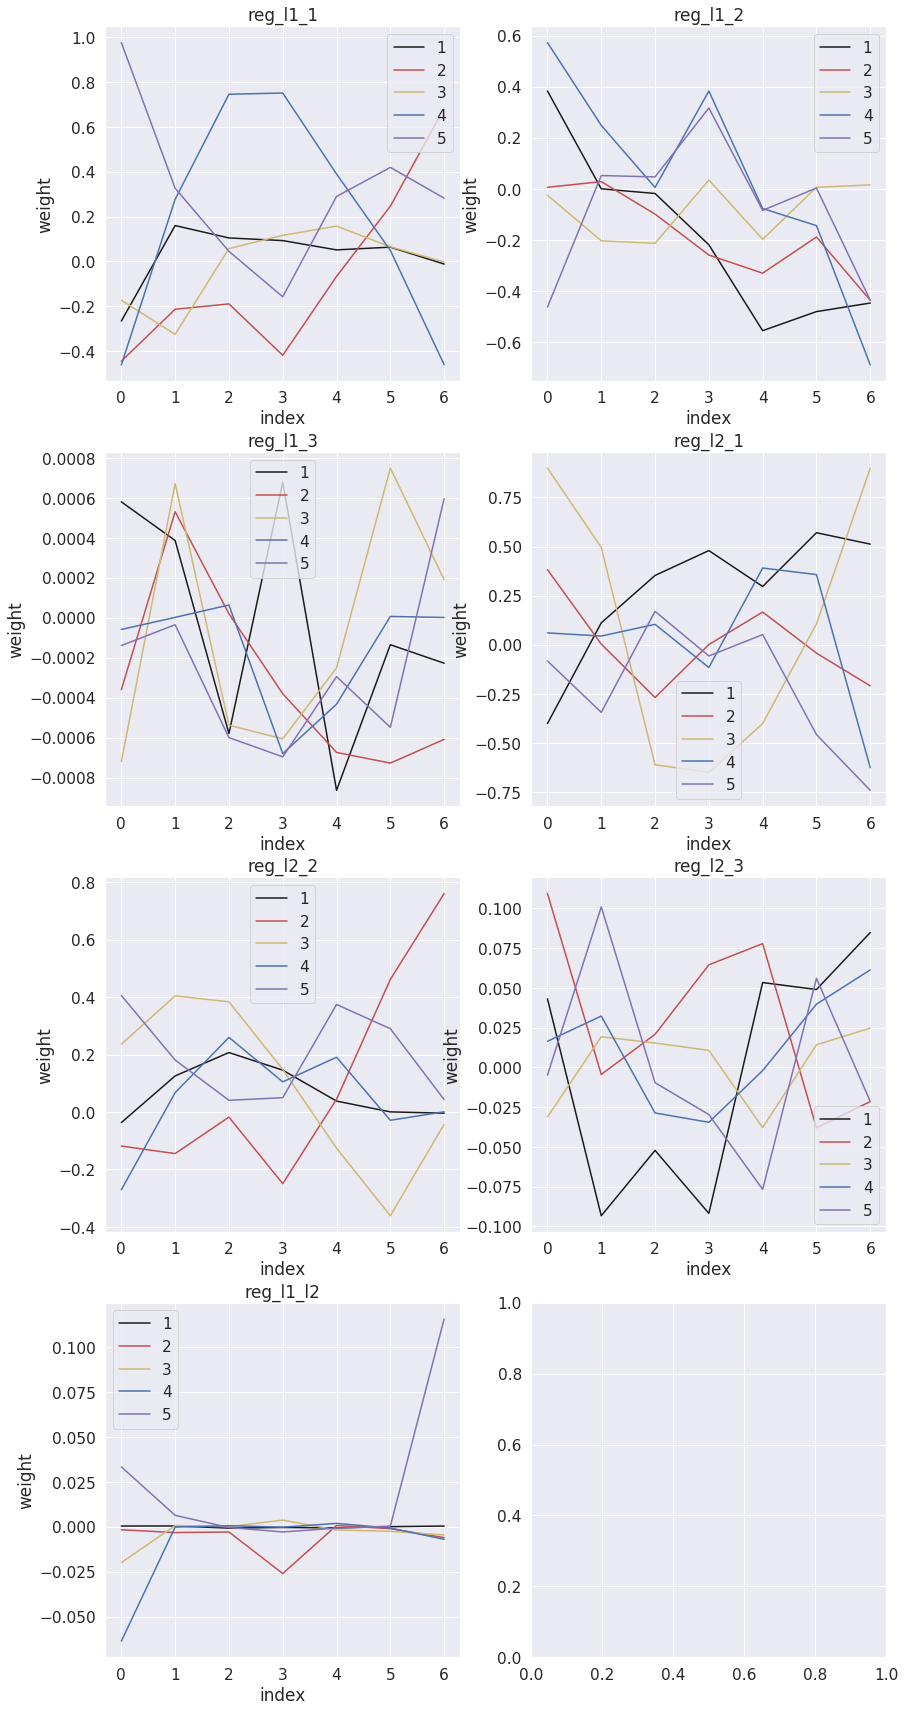

In [25]:
fig, ax = plt.subplots(4,2,figsize=(14,30))
ax_dict = {'reg_l1_1': ax[0][0], 'reg_l1_2': ax[0][1], 'reg_l1_3': ax[1][0],
           'reg_l2_1': ax[1][1], 'reg_l2_2': ax[2][0],
          'reg_l2_3': ax[2][1], 'reg_l1_l2': ax[3][0]}

c = ['k','r','y','b','m']
def plot_w(w, ax):
    ''' Plot weights of convol layer '''
    for i in range(len(w)):
        ax.plot(w[i][0], c[i], label=str(i+1))
    ax.set_ylabel('weight')
    ax.set_xlabel('index')
    ax.legend()

#Setting names
for key in ax_dict:
    ax_dict[key].set_title(key)
    
# Following Baiesi's lecture
for model, reg in zip(model_list, ax_dict.keys()):    
    # the second Conv1D layer is the number 2
    # to check this control the x axis
    # the last value of the x axis must be equal to
    # kernel_size (of the layer) - 1
    filters, biases = model.layers[2].get_weights()
    w0T = filters.T
    plot_w(w0T, ax_dict[reg])
    
plt.show()


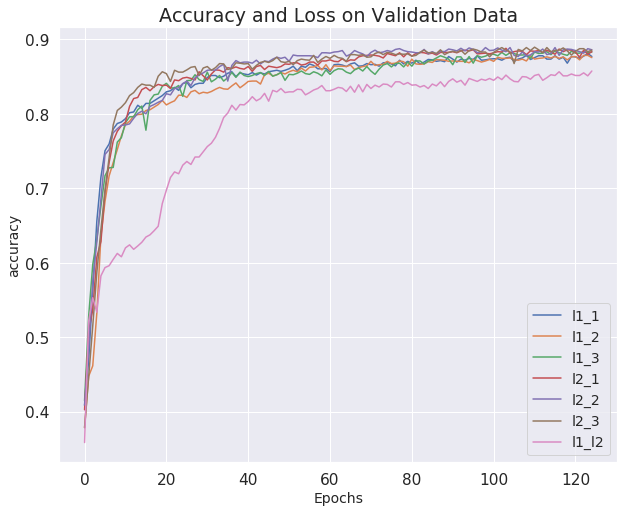

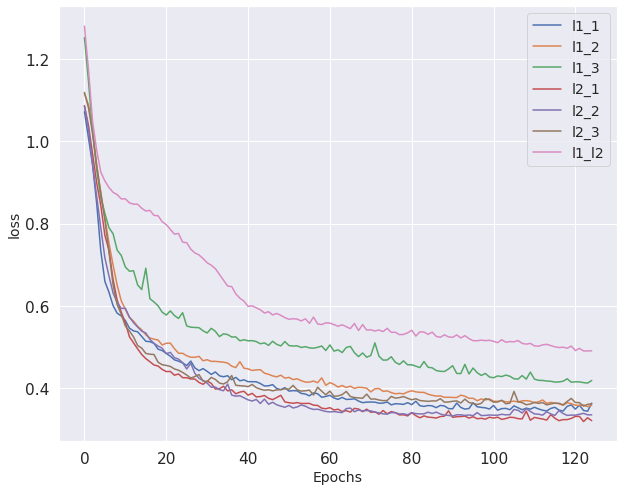

In [26]:
reg=['l1_1','l1_2','l1_3','l2_1','l2_2','l2_3','l1_l2']

# Accuracy
plt.figure(figsize=(10,8))
for fit ,test in zip(fits,reg):
    
    #plt.plot(fit.history['accuracy'], '--',
    #            label = test + ' - training data')
    
    plt.plot(fit.history['val_accuracy'],
            label = test ) 

fontsize = 14
plt.ylabel('accuracy', fontsize=fontsize)
plt.xlabel('Epochs', fontsize=fontsize)
plt.legend(loc='lower right', fontsize=fontsize)    
plt.title('Accuracy and Loss on Validation Data', fontsize=fontsize+5)
plt.show()

# Loss
plt.figure(figsize=(10,8))
for fit, test in zip(fits,reg):
    
    #plt.plot(fit.history['loss'], '--',
    #        label = test + ' - training data')
    
    plt.plot(fit.history['val_loss'],
            label = test ) 

fontsize = 14
plt.ylabel('loss', fontsize=fontsize)
plt.xlabel('Epochs', fontsize=fontsize)
plt.legend(loc='upper right', fontsize=fontsize)    
plt.show()

In [27]:
create_model(**t6, summary=True)

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_84 (Conv1D)           (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d_48 (Averag (None, 10, 5)             0         
_________________________________________________________________
conv1d_85 (Conv1D)           (None, 4, 5)              180       
_________________________________________________________________
flatten_48 (Flatten)         (None, 20)                0         
_________________________________________________________________
dense_114 (Dense)            (None, 10)                210       
_________________________________________________________________
dropout_48 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_115 (Dense)            (None, 3)               

(<keras.engine.sequential.Sequential at 0x7f50bbdec198>, 483)